## Imports et préparation

In [15]:
# --- Imports nécessaires ---
import os
import re
from collections import defaultdict

# --- Chemin vers le corpus ---
path = "../../data/txt_tp4"  # à adapter selon ton organisation
files = sorted(os.listdir(path))
print(f"Nombre total de fichiers trouvés : {len(files)}")


Nombre total de fichiers trouvés : 999


### fusion de textes si besoin

In [16]:
# --- Étape 1 : Fusionner les textes d'un même article si nécessaire ---
# Ici, chaque fichier correspond à un article unique
corpus = {}
for f in files:
    if f.startswith("KB_") and f.endswith(".txt"):
        filepath = os.path.join(path, f)
        try:
            with open(filepath, "r", encoding="utf-8") as file:
                text = file.read().strip()
                # Si article déjà présent (doublon), on concatène
                if f in corpus:
                    corpus[f] += "\n" + text
                else:
                    corpus[f] = text
        except UnicodeDecodeError:
            # Si problème d'encodage, on tente avec latin-1
            with open(filepath, "r", encoding="latin-1") as file:
                text = file.read().strip()
                corpus[f] = text

print(f"Nombre d'articles après lecture : {len(corpus)}")


Nombre d'articles après lecture : 998


### Suppression des doublons exacts

In [17]:
# --- Étape 2 : Supprimer les doublons exacts ---
texts_seen = set()
clean_corpus = {}
for fname, text in corpus.items():
    normalized_text = text.lower()  # pour comparer sans tenir compte de la casse
    if normalized_text not in texts_seen:
        texts_seen.add(normalized_text)
        clean_corpus[fname] = text

print(f"Nombre d'articles uniques après suppression des doublons : {len(clean_corpus)}")


Nombre d'articles uniques après suppression des doublons : 998


### Uniformisation du texte
#### en supprimant les caractere inutilse, en uniformisant les espaces et les callses

In [18]:
# --- Étape 3 : Uniformiser ponctuation et espaces ---
def clean_text(text):
    # Supprimer les métadonnées inutiles (ex: ### FILENAME ###)
    text = re.sub(r'###.*?###|\[.*?\]|\{.*?\}|<.*?>', '', text) 
    # Remplacer les sauts de ligne multiples par un seul espace
    text = re.sub(r'\s+', ' ', text).strip()
    # Supprimer ponctuation superflue (garder . , ! ?)
    text = re.sub(r'[^\w\s\.\,\!\?\'\-]', '', text)
    # Convertir tout en minuscules
    text = text.lower()
    return text
    

for fname in clean_corpus:
    clean_corpus[fname] = clean_text(clean_corpus[fname])


### Filtrer les mots et les expressions spécifiques

#### Ne pas prendre en compte le nom propre Gay dans l'analyse

In [20]:
def filter_proper_nouns(text):
    # Supprime UNIQUEMENT "Gay" en majuscule (nom propre)
    text = re.sub(r'\bGay\b', '', text)  # "Gay" → supprimé, "gay" → conservé

    # Gestion fine de "trans" pour éviter les faux positifs
    # Liste des mots contenant "trans" à PROTÉGER (ex: transport)
    protected_trans = [
        r'\btransport(s?)\b', r'\btransatlantique\b',
        r'\btransmission\b', r'\btransformer\b', r'\btransitoire\b'
    ]
    # Remplace temporairement les termes protégés par un marqueur
    for term in protected_trans:
        text = re.sub(term, lambda m: f"PROTECTED_{m.group(0).upper()}_TERM", text, flags=re.IGNORECASE)

    # Supprime "trans" SEUL (ex: "transgenre" reste intact)
    text = re.sub(r'\btrans\b(?!\w)', '', text)  # "trans" isolé → supprimé

    # Restaure les termes protégés
    text = re.sub(r'PROTECTED_(.*?)_TERM', lambda m: m.group(1).lower(), text)

    # Nettoyage final
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [19]:
def filter_proper_nouns(text):
    # Exemple : supprimer "Gay" si c’est un nom propre
    text = re.sub(r'\bGay\b', '', text)
    # TODO : ajouter d'autres filtres si besoin
    return text

for fname in clean_corpus:
    clean_corpus[fname] = filter_proper_nouns(clean_corpus[fname])

## Sauvgarder corpus nettoyé

In [21]:
# --- Étape 5 : Enregistrer le corpus nettoyé dans un fichier unique ---
output_path = "../../data/clean_corpus.txt"
with open(output_path, "w", encoding="utf-8") as out_file:
    for fname, text in clean_corpus.items():
        out_file.write(f"### {fname} ###\n")
        out_file.write(text + "\n\n")

print(f"Corpus nettoyé et fusionné enregistré dans : {output_path}")


Corpus nettoyé et fusionné enregistré dans : ../../data/clean_corpus.txt


### Refaire ce qui as été fait dans le S1_explore pour voir si en nettoyant on a une grande difference de resultat

Nombre d'articles par journal :
Le Soir: 998

Nombre d'articles par décennie :
1950s: 441
1960s: 517
1970s: 40

Nombre d'articles par mois :
Mois 1: 54
Mois 2: 74
Mois 3: 79
Mois 4: 88
Mois 5: 81
Mois 6: 93
Mois 7: 93
Mois 8: 86
Mois 9: 88
Mois 10: 64
Mois 11: 88
Mois 12: 110


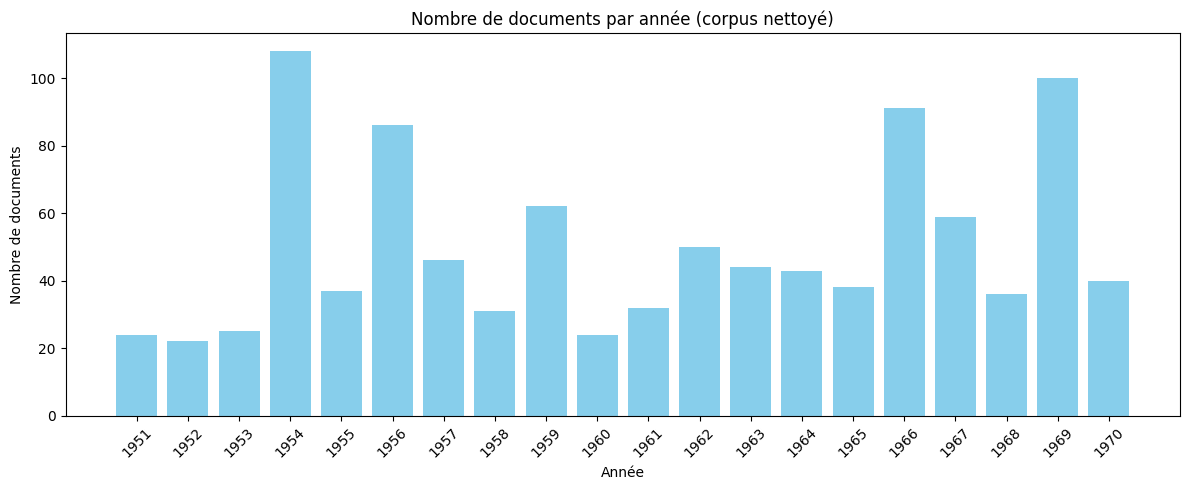

In [24]:
# --- Imports nécessaires ---
from collections import defaultdict
import matplotlib.pyplot as plt

# --- Initialisation des compteurs ---
count_decade = defaultdict(int)
count_month = defaultdict(int)
count_newspapers = defaultdict(int)
covered_years = set()

# --- Parcours du corpus nettoyé ---
for fname, text in clean_corpus.items():
    # On suppose que le nom du fichier est encore dans la clé (ex: KB_427_1920-01.txt)
    elems = fname.split("_")
    if len(elems) >= 3:
        newspaper = elems[1]
        date_parts = elems[2].split("-")
        if len(date_parts) >= 2:
            year = date_parts[0]
            month = int(date_parts[1])
            decade = year[:3] + "0s"

            count_decade[decade] += 1
            count_newspapers[newspaper] += 1
            count_month[month] += 1
            covered_years.add(year)
        else:
            print(f"Date malformed in key: {fname}")
    else:
        print(f"Key malformed: {fname}")

# --- Affichage du nombre d'articles par journal ---
print("Nombre d'articles par journal :")
for j, c in count_newspapers.items():
    print(f"{journal_names.get(j, j)}: {c}")

# --- Affichage du nombre d'articles par décennie ---
print("\nNombre d'articles par décennie :")
for d, c in count_decade.items():
    print(f"{d}: {c}")

# --- Affichage du nombre d'articles par mois ---
print("\nNombre d'articles par mois :")
for m, c in sorted(count_month.items()):
    print(f"Mois {m}: {c}")

# --- Graphique 1 : Nombre de documents par année ---
years_sorted = sorted(covered_years)
counts_per_year = [
    sum(1 for fname in clean_corpus if fname.split("_")[2].split("-")[0] == y)
    for y in years_sorted
]

plt.figure(figsize=(12, 5))
plt.bar(years_sorted, counts_per_year, color='skyblue')
plt.xlabel("Année")
plt.ylabel("Nombre de documents")
plt.title("Nombre de documents par année (corpus nettoyé)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
